## Library version check

In [1]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
print("xgboost version: {}".format(xgb.__version__)) ## 1.2.1

c:\Users\USER\anaconda3\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


xgboost version: 1.2.1


## 0. load the libararies

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

## 1. train.csv 전처리

#####  - time series를 일반 regression 문제로 변환하기 위해 시간 관련 변수 추가(월 / 주 / 요일)
#####  - 전력소비량의 건물별 요일별 시간대별 평균 / 건물별 시간대별 평균 / 건물별 시간대별 표준편차 변수 추가
###### 건물별 요일별 시간대별 표준편차 / 건물별 평균 등 여러 통계량 생성 후 몇개 건물에 테스트, 최종적으로 성능 향상에 도움이 된 위 3개 변수만 추가
#####  - 공휴일 변수 추가
#####  - 시간을 sin time, cos time 변수 추가 -- 시간에 대한 이산푸리에변환(DFT)
#####  - CDH(Cooling Degree Hour) & THI(불쾌지수) 변수 추가

##### - 건물별 모델 생성 시 무의미한 태양광 발전 시설 / 냉방시설 변수 삭제
##### - building info() 데이터를 사용할 수 있는 방법 생각해보기

In [3]:
train = pd.read_csv('./data/train.csv')
train.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [4]:
## 변수 영문명으로 변경
cols = ['num_date_time','num', 'date_time', 'temp', 'prec','wind' ,'hum', 'hr', 'mj/m2', 'power']
train.columns = cols
train.head()

,num_date_time,num,date_time,temp,prec,wind,hum,hr,mj/m2,power
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [5]:
# train.csv 에만 있는 열 제거 num_date_time, hr, mj/m2
train = train.drop(['num_date_time','hr','mj/m2'], axis=1)
train.head()

,num,date_time,temp,prec,wind,hum,power
0,1,20220601 00,18.6,NaN,0.9,42.0,1085.28
1,1,20220601 01,18.0,NaN,1.1,45.0,1047.36
2,1,20220601 02,17.7,NaN,1.5,45.0,974.88
3,1,20220601 03,16.7,NaN,1.4,48.0,953.76
4,1,20220601 04,18.4,NaN,2.8,43.0,986.40


### 결측치 처리

In [6]:
train.isnull().sum()

num               0
date_time         0
temp              0
prec         160069
wind             19
hum               9
power             0
dtype: int64

In [7]:
# 강수량 결측치 0.0으로 채우기
train['prec'].fillna(0.0, inplace=True)

In [8]:
# wind, hum 결측치 보간법으로 채우기
train.wind = train.wind.interpolate(method = 'polynomial', order = 3)
train.hum = train.hum.interpolate(method = 'polynomial', order = 3)

In [9]:
train.isnull().sum()

num          0
date_time    0
temp         0
prec         0
wind         0
hum          0
power        0
dtype: int64

### 날짜 형식 변경하고 날짜형식 열 추가

In [11]:
# 시간 관련 변수들 생성
# month 변수는 week 변수랑 상관계수가 0.9x로 나와서 제외함
train.date_time = pd.to_datetime(train.date_time)
train['hour'] = train.date_time.dt.hour
train['day'] = train.date_time.dt.weekday
train['week'] = train.date_time.dt.weekofyear
train.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_4320\3356464219.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['week'] = train.date_time.dt.weekofyear


,num,date_time,temp,prec,wind,hum,power,hour,day,week
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,0,2,22
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,1,2,22
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,2,2,22
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,3,2,22
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,4,2,22


34번 , 56번 이상치 확인 -- 어떻게??
이상치 보간법으로 값 대체

<Axes: xlabel='date_time', ylabel='power'>

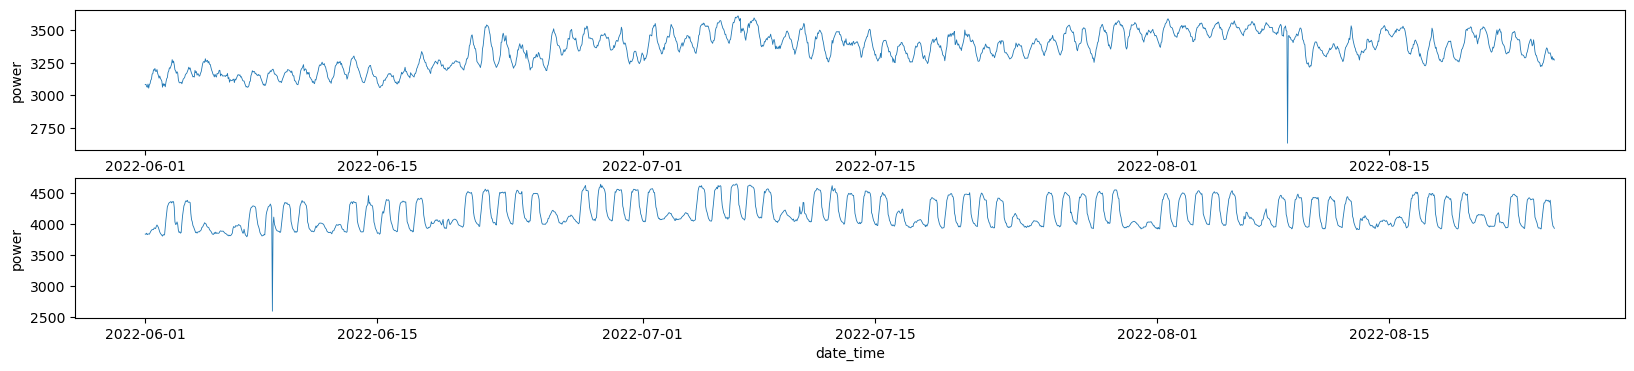

In [12]:
num_34 = train[train.num == 34]
num_56 = train[train.num == 56]

fig = plt.figure(figsize = (20,4))
plt.subplot(211)
sns.lineplot(data = num_34, x = 'date_time', y = 'power',linewidth = 0.6)
plt.subplot(212)
sns.lineplot(data = num_56, x = 'date_time', y = 'power',linewidth = 0.6)

In [13]:
#보간 이전 값
train.loc[(train.date_time == '2022-08-08 21:00:00')& (train.num == 34), 'power'],
train.loc[(train.date_time == '2022-06-08 16:00:00')& (train.num == 56), 'power']

112384    2589.84
Name: power, dtype: float64

In [14]:
train.loc[(train.date_time == '2022-08-08 21:00:00')& (train.num == 34), 'power'] = np.nan
train.loc[(train.date_time == '2022-06-08 16:00:00')& (train.num == 56), 'power'] = np.nan

In [15]:
#보간법 실행
train.power = train.power.interpolate(method = 'polynomial', order = 3)

In [ ]:
#보간 이후 값
train.loc[(train.date_time == '2022-08-08 21:00:00')& (train.num == 34), 'power'],
train.loc[(train.date_time == '2022-06-08 16:00:00')& (train.num == 56), 'power']

112384    4065.2309
Name: power, dtype: float64

<Axes: xlabel='date_time', ylabel='power'>

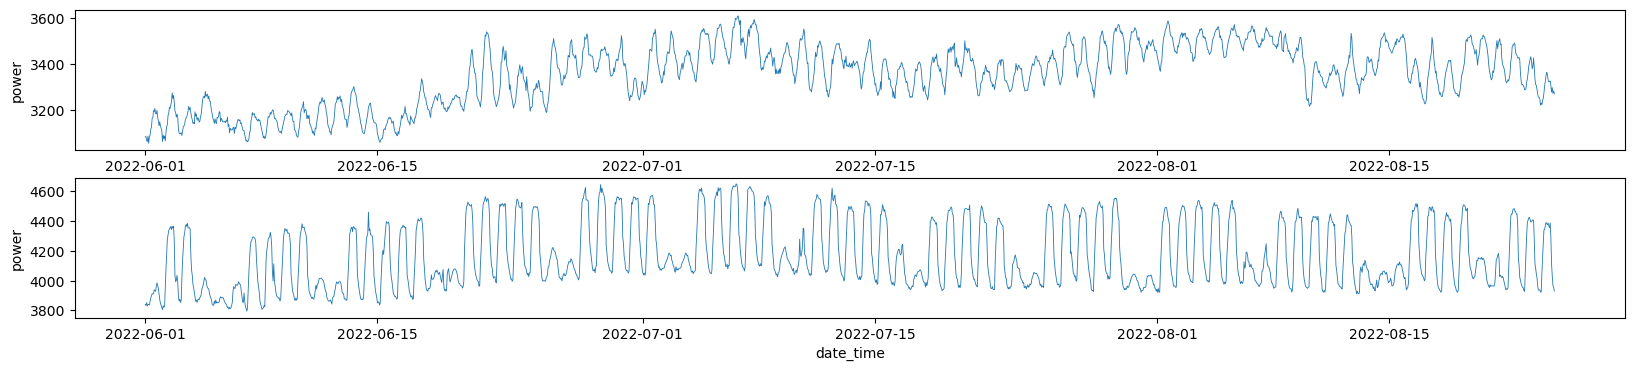

In [16]:
num_34 = train[train.num == 34]
num_56 = train[train.num == 56]

fig = plt.figure(figsize = (20,4))
plt.subplot(211)
sns.lineplot(data = num_34, x = 'date_time', y = 'power',linewidth = 0.6)
plt.subplot(212)
sns.lineplot(data = num_56, x = 'date_time', y = 'power',linewidth = 0.6)

In [17]:
train.head()

,num,date_time,temp,prec,wind,hum,power,hour,day,week
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,0,2,22
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,1,2,22
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,2,2,22
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,3,2,22
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,4,2,22


### 건물별 요일별 시간별 발전량 평균 열 추가

In [18]:
## 건물별, 요일별, 시간별 발전량 평균 넣어주기
power_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['day_hour_mean'] = train.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'power'].values[0], axis = 1)

  0%|          | 0/204000 [00:00<?, ?it/s]

100%|██████████| 204000/204000 [01:31<00:00, 2222.73it/s]


In [19]:
## 건물별 요일별 시간별 발전량 표준편차 넣어주기
power_hour_std = pd.pivot_table(train, values = 'power', index = ['num', 'hour', 'day'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['day_hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) & (power_hour_std.day == x['day']) ,'power'].values[0], axis = 1)
train.head()

  0%|          | 0/204000 [00:00<?, ?it/s]

100%|██████████| 204000/204000 [02:14<00:00, 1520.49it/s]


,num,date_time,temp,prec,wind,hum,power,hour,day,week,day_hour_mean,day_hour_std
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,0,2,22,1774.744615,517.982222
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,1,2,22,1687.347692,500.769931
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,2,2,22,1571.483077,465.227458
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,3,2,22,1522.153846,436.601091
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,4,2,22,1506.793846,405.518091


### 공휴일 변수 추가, 대체공휴일 적용

In [20]:
### 공휴일 변수 추가
### 공휴일이면 1 아니면 0
### 6월 1일, 6월 6일, 8월 15일 임시공휴일로 지정이므로 1로 변경
train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
train.loc[('2022-06-01'<=train.date_time)&(train.date_time<'2022-06-02'), 'holiday'] = 1
train.loc[('2022-06-06'<=train.date_time)&(train.date_time<'2022-06-07'), 'holiday'] = 1
train.loc[('2022-08-15'<=train.date_time)&(train.date_time<'2022-08-16'), 'holiday'] = 1
train.head()

,num,date_time,temp,prec,wind,hum,power,hour,day,week,day_hour_mean,day_hour_std,holiday
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,0,2,22,1774.744615,517.982222,1
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,1,2,22,1687.347692,500.769931,1
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,2,2,22,1571.483077,465.227458,1
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,3,2,22,1522.153846,436.601091,1
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,4,2,22,1506.793846,405.518091,1


In [21]:
## 시간에 대한 이산푸리에변환 (DFT)
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

In [22]:
## 불쾌지수 변수 THI 추가
train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

기온(temperature) 변수는 설명력이 다소 부족합니다. 냉방 전력소요의 측면에서 보았을 때, 전력 사용량은 기온이 변함에 따라 즉각적으로 변화하진 않기 때문입니다.
냉방전력소요와 관련하여, CDH(cooling degree hour, 냉방도일) 이라는 개념을 조금 변형하여 적용해 보았습니다.  
냉방 기준온도(26도)보다 높은 시점에서 해당 시점의 온도와 기준온도의 차를 적산하여 구할 수 있습니다.  
이렇게 구해진 CDH 라는 변수는, 기온보다 냉방 수요에 대한 설명력이 높습니다. 결과를 시각화 해 보겠습니다.

In [23]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-24))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-24))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101,1):
    temp = train[train['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

In [24]:
### 불필요 변수 제거
train.drop(['hour'], axis = 1, inplace = True)
train.head()

,num,date_time,temp,prec,wind,hum,power,day,week,day_hour_mean,day_hour_std,holiday,sin_time,cos_time,THI,CDH
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,2,22,1774.744615,517.982222,1,0.000000,1.000000,49.6576,-5.4
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,2,22,1687.347692,500.769931,1,0.258819,0.965926,47.7625,-11.4
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,2,22,1571.483077,465.227458,1,0.500000,0.866025,47.2225,-17.7
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,2,22,1522.153846,436.601091,1,0.707107,0.707107,44.7856,-25.0
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,2,22,1506.793846,405.518091,1,0.866025,0.500000,49.0061,-30.6


In [25]:
train = train[['num', 'date_time','power', 'prec', 'wind', 'hum', 'temp', 'day',
       'week', 'day_hour_mean', 'day_hour_std', 'holiday',
       'sin_time', 'cos_time', 'THI', 'CDH']]
train.head()

,num,date_time,power,prec,wind,hum,temp,day,week,day_hour_mean,day_hour_std,holiday,sin_time,cos_time,THI,CDH
0,1,2022-06-01 00:00:00,1085.28,0.0,0.9,42.0,18.6,2,22,1774.744615,517.982222,1,0.000000,1.000000,49.6576,-5.4
1,1,2022-06-01 01:00:00,1047.36,0.0,1.1,45.0,18.0,2,22,1687.347692,500.769931,1,0.258819,0.965926,47.7625,-11.4
2,1,2022-06-01 02:00:00,974.88,0.0,1.5,45.0,17.7,2,22,1571.483077,465.227458,1,0.500000,0.866025,47.2225,-17.7
3,1,2022-06-01 03:00:00,953.76,0.0,1.4,48.0,16.7,2,22,1522.153846,436.601091,1,0.707107,0.707107,44.7856,-25.0
4,1,2022-06-01 04:00:00,986.40,0.0,2.8,43.0,18.4,2,22,1506.793846,405.518091,1,0.866025,0.500000,49.0061,-30.6


### 상관성 높은 변수 빼는 과정

month 와 week 상관계수가 0.9 이상이여서 month 제거  
day_hour_mean, hour_mean 상관계수가 0.9 이상이여서 hour_mean 제거하고 표준편차도 day_hour_mean 으로 생성


In [ ]:
# cor_mat = train.iloc[:, 3:].corr()
# cor_mat

In [ ]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(cor_mat, annot=True, cmap='coolwarm', center=0)
# plt.title('독립변수들 간의 상관성 히트맵')
# plt.show()

### power 열의 추가 이상치 처리 하기


In [26]:
train.columns

Index(['num', 'date_time', 'power', 'prec', 'wind', 'hum', 'temp', 'day',
       'week', 'day_hour_mean', 'day_hour_std', 'holiday', 'sin_time',
       'cos_time', 'THI', 'CDH'],
      dtype='object')

In [27]:
#이상치 처리
train.loc[(train.num == 35) & (train.date_time == '2022-08-08 21:00:00'), 'power'] = np.nan
#75번 건물
train.loc[(train.num == 75) & (train.date_time == '2022-07-30 17:00:00'), 'power'] = np.nan
#95번 건물
train.loc[(train.num == 95) & (train.date_time == '2022-07-27 16:00:00'), 'power'] = np.nan
train.loc[(train.num == 95) & (train.date_time == '2022-07-27 17:00:00'), 'power'] = np.nan

train.isna().sum()
#보간법 실행
train.power = train.power.interpolate(method = 'polynomial', order = 3)

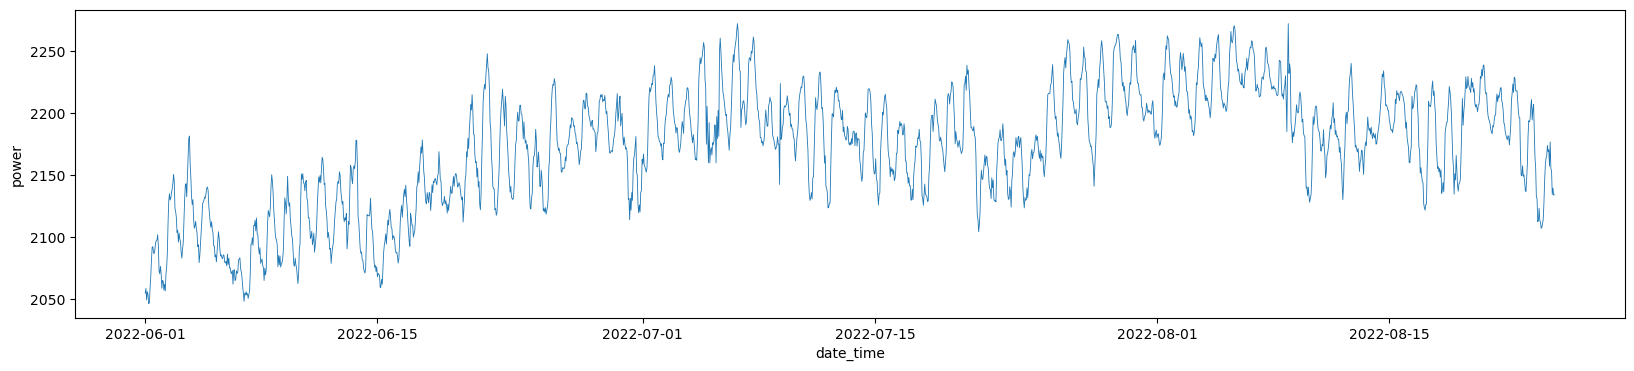

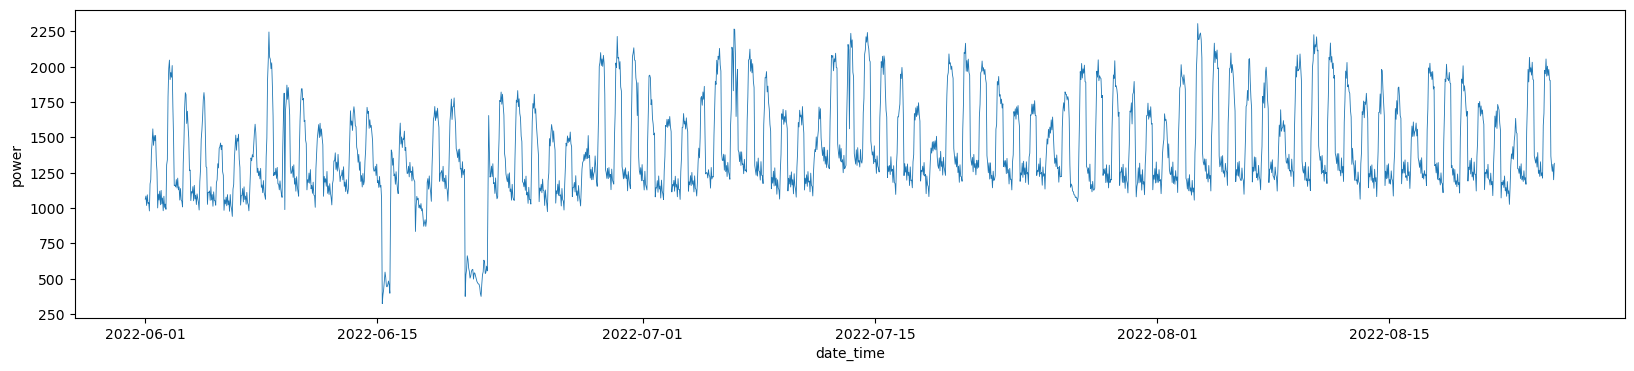

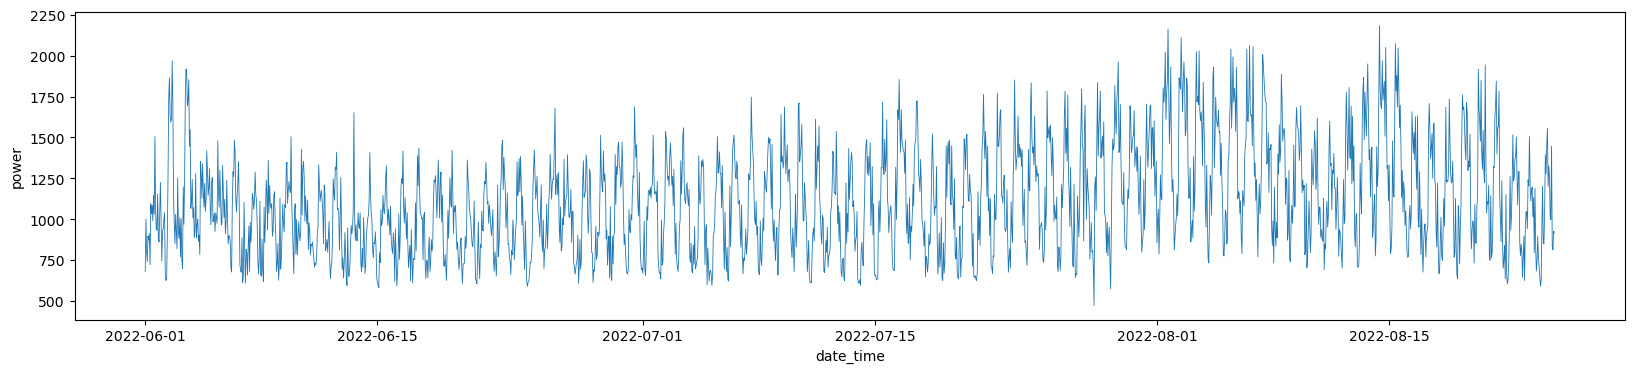

In [28]:
#그래프 - 보간 이후
anomaly = [35, 75, 95]

for num in anomaly:
  temp = train[train.num == num]
  plt.figure(figsize = (20,4))
  sns.lineplot(data = temp, x= 'date_time', y = 'power', linewidth = 0.6)

In [29]:
train.to_csv('./data/xgboost/train_preprocessed.csv')

### 태양열 에너지 저장 장치 있는 건물

In [30]:
#반비례 관계에 있는 건물들 list
solar_comp_list = [57,12,76,72,71,73,49,27,93,16,30, 48,46,74,60]

#반비례 관계에 있는 건물들만 solar_flag 추가
#1 = 반비례 관계, 0 = 태양광 저장 장치가 없거나 일사량과 저장 장치 사이에 유의미한 관계가 없는 건물들
train['solar_flag'] = 0
for comp in solar_comp_list:
  train.loc[train.num == comp, 'solar_flag'] = 1

#값 확인
len(solar_comp_list), train[train.solar_flag == 1].num.nunique()

(15, 15)

In [31]:
## save the preprocessed data
#기존
#train = pd.read_csv('/content/drive/MyDrive/dacon-전력 사용량 예측 공모전/전력사용량 예측 공모전/data/xgboost/train_preprocessed.csv')
#추가
train.to_csv('./data/xgboost/train_preprocessed_incsolar.csv')

---

## test.csv 전처리

In [33]:
test = pd.read_csv('./data/test.csv')
test.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [34]:
cols = ['num_date_time','num', 'date_time', 'temp', 'prec','wind' ,'hum']
test.columns = cols

In [35]:
test.isnull().sum()

num_date_time    0
num              0
date_time        0
temp             0
prec             0
wind             0
hum              0
dtype: int64

In [36]:
test.drop(['num_date_time'], axis = 1, inplace = True)
test.head()

,num,date_time,temp,prec,wind,hum
0,1,20220825 00,23.5,0.0,2.2,72
1,1,20220825 01,23.0,0.0,0.9,72
2,1,20220825 02,22.7,0.0,1.5,75
3,1,20220825 03,22.1,0.0,1.3,78
4,1,20220825 04,21.8,0.0,1.0,77


In [38]:
# 시간 관련 변수들 생성
test.date_time = pd.to_datetime(test.date_time)
test['hour'] = test.date_time.dt.hour
test['day'] = test.date_time.dt.weekday
test['week'] = test.date_time.dt.weekofyear
test.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_4320\3639925981.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test['week'] = test.date_time.dt.weekofyear


,num,date_time,temp,prec,wind,hum,hour,day,week
0,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,0,3,34
1,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,1,3,34
2,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,2,3,34
3,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,3,3,34
4,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,4,3,34


In [39]:
## 건물별 시간별 발전량 표준편차 넣어주기
## 건물별, 요일별, 시간별 발전량 평균 넣어주기
## train 전처리 시 정의한 power_mean, power_hour_std 사용
tqdm.pandas()
test['day_hour_mean'] = test.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'power'].values[0], axis = 1)
tqdm.pandas()
test['day_hour_std'] = test.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) & (power_hour_std.day == x['day']) ,'power'].values[0], axis = 1)
test.head()

100%|██████████| 16800/16800 [00:06<00:00, 2573.13it/s]


,num,date_time,temp,prec,wind,hum,hour,day,week,day_hour_mean,day_hour_std
0,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,0,3,34,1627.80,446.984913
1,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,1,3,34,1550.08,449.091398
2,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,2,3,34,1431.12,415.453568
3,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,3,3,34,1372.20,378.117772
4,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,4,3,34,1381.72,360.348483


In [40]:
### 공휴일 변수 추가
test['holiday'] = test.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

In [41]:
## 시간에 대한 이산푸리에변환 (DFT)
## 시간 변수 제거
test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)
test.drop(['hour'], axis = 1, inplace = True)

In [42]:
# 불쾌지수 변수 THI 추가
test['THI'] = 9/5*test['temp'] - 0.55*(1-test['hum']/100)*(9/5*test['hum']-26)+32

In [43]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-24))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-24))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101,1):
    temp = test[test['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

In [44]:
# 슬라이싱을 train 과 똑같이 바꿈
test = test[['num', 'date_time', 'prec', 'wind', 'hum', 'temp', 'day',
       'week', 'day_hour_mean', 'day_hour_std', 'holiday',
       'sin_time', 'cos_time', 'THI', 'CDH']]

In [45]:
test.head()

,num,date_time,prec,wind,hum,temp,day,week,day_hour_mean,day_hour_std,holiday,sin_time,cos_time,THI,CDH
0,1,2022-08-25 00:00:00,0.0,2.2,72,23.5,3,34,1627.80,446.984913,0,0.000000,1.000000,58.3456,-0.5
1,1,2022-08-25 01:00:00,0.0,0.9,72,23.0,3,34,1550.08,449.091398,0,0.258819,0.965926,57.4456,-1.5
2,1,2022-08-25 02:00:00,0.0,1.5,75,22.7,3,34,1431.12,415.453568,0,0.500000,0.866025,57.8725,-2.8
3,1,2022-08-25 03:00:00,0.0,1.3,78,22.1,3,34,1372.20,378.117772,0,0.707107,0.707107,57.9376,-4.7
4,1,2022-08-25 04:00:00,0.0,1.0,77,21.8,3,34,1381.72,360.348483,0,0.866025,0.500000,56.9961,-6.9


In [46]:
test.to_csv('./data/xgboost/test_preprocessed.csv')

In [47]:
#반비례 관계에 있는 건물들 list
solar_comp_list = [57,12,76,72,71,73,49,27,93,16,30, 48,46,74,60]

#반비례 관계에 있는 건물들만 solar_flag 추가
#1 = 반비례 관계, 0 = 태양광 저장 장치가 없거나 일사량과 저장 장치 사이에 유의미한 관계가 없는 건물들
test['solar_flag'] = 0
for comp in solar_comp_list:
  test.loc[test.num == comp, 'solar_flag'] = 1

#값 확인
len(solar_comp_list), test[test.solar_flag == 1].num.nunique()

(15, 15)

In [48]:
#기존
#test.to_csv('/content/drive/MyDrive/전력사용량 예측 공모전/data/xgboost/test_preprocessed.csv')
#추가
test.to_csv('./data/xgboost/test_preprocessed_incsolar.csv')

In [49]:
test.head()

,num,date_time,prec,wind,hum,temp,day,week,day_hour_mean,day_hour_std,holiday,sin_time,cos_time,THI,CDH,solar_flag
0,1,2022-08-25 00:00:00,0.0,2.2,72,23.5,3,34,1627.80,446.984913,0,0.000000,1.000000,58.3456,-0.5,0
1,1,2022-08-25 01:00:00,0.0,0.9,72,23.0,3,34,1550.08,449.091398,0,0.258819,0.965926,57.4456,-1.5,0
2,1,2022-08-25 02:00:00,0.0,1.5,75,22.7,3,34,1431.12,415.453568,0,0.500000,0.866025,57.8725,-2.8,0
3,1,2022-08-25 03:00:00,0.0,1.3,78,22.1,3,34,1372.20,378.117772,0,0.707107,0.707107,57.9376,-4.7,0
4,1,2022-08-25 04:00:00,0.0,1.0,77,21.8,3,34,1381.72,360.348483,0,0.866025,0.500000,56.9961,-6.9,0
